# Advanced ML Algorithm Comparison for Solar Production Prediction

**Goal**: Compare ML algorithms with hyperparameter tuning to select the best model

## Algorithms to Compare:
1. **Ridge Regression** - Linear baseline with regularization
2. **Random Forest** - Ensemble of decision trees
3. **Gradient Boosting** - Sequential ensemble
4. **XGBoost** - Advanced gradient boosting
5. **Support Vector Regression (SVR)** - Kernel-based regression
6. **LSTM Neural Network** - Deep learning for time series

## Advanced Features:
- ⚙️ **Hyperparameter Tuning** - GridSearchCV/RandomizedSearchCV
- 📊 **Time Series CV** - Proper validation for sequential data
- 🔍 **Feature Importance** - Understand what drives predictions
- 📈 **3-Line Comparison** - Actual vs ML vs Clear-Sky

## Evaluation:
- **MAE** - Average prediction error
- **RMSE** - Penalizes large errors
- **R² Score** - Variance explained
- **MAPE** - Percentage error

In [22]:
# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import time

# Solar
import pvlib
from pvlib.location import Location

# ML models
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Try XGBoost
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("⚠️  XGBoost not installed")

# Try Keras/TensorFlow for LSTM

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
KERAS_AVAILABLE = True
# Suppress TensorFlow warnings
tf.get_logger().setLevel('ERROR')


# Environment
from dotenv import load_dotenv
import os

# Config
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100
pd.set_option('display.max_columns', None)

load_dotenv()

print("✅ Core imports loaded")
print(f"   XGBoost: {'✓' if XGBOOST_AVAILABLE else '✗'}")
print(f"   Keras/TensorFlow: {'✓' if KERAS_AVAILABLE else '✗'}")

✅ Core imports loaded
   XGBoost: ✓
   Keras/TensorFlow: ✓


In [23]:
# Configuration
PLANT_CONFIG = {
    'name': 'HKL (GGI)',
    'capacity_kwp': 269.28,
    'latitude': 24.022350694140282,
    'longitude': 90.29576719011767,
    'timezone': 'Asia/Dhaka',
    'typical_pr': 0.82
}

DATA_PATHS = {
    'inverter_plants': 'data/inverter_plants.csv',
    'generation_5m': 'data/inverter_five_minutes_generation_logs.csv',
    'weather': 'open_data/gazipur_weather.csv'
}

ML_CONFIG = {
    'train_test_split_date': '2024-09-01',
    #'train_test_split_date': '2024-12-31',
    'min_sun_elevation': 5,
    'tune_hyperparameters': True,  # Set to False to skip tuning
    'cv_splits': 3,  # Time series CV splits for tuning
    'lstm_lookback': 24,  # Hours of history for LSTM
    'lstm_epochs': 50,
    'lstm_batch_size': 32
}

## Step 1: Load and Prepare Data

In [24]:
def load_complete_dataset():
    """
    Load and prepare complete dataset with all features.
    """
    print("📊 Loading complete dataset...")

    # Load plant data
    df_plants = pd.read_csv(DATA_PATHS['inverter_plants'])
    df_plants['plant_address'] = df_plants['plant_address'].fillna('Gazipur')

    # Load 5-min generation
    df = pd.read_csv(DATA_PATHS['generation_5m'])
    df['generation_date'] = pd.to_datetime(df['generation_date'])
    df = df.merge(df_plants[['plant_id', 'plant_name']], on='plant_id', how='left')
    df = df[df['plant_name'] == PLANT_CONFIG['name']].copy()

    # Clean
    df['generation_amount'] = df['generation_amount'].astype(str).str.replace(',', '').astype(float)
    df['generation_kwh'] = df['generation_amount'] / 1000

    if df['generation_date'].dt.tz is None:
        df['generation_date'] = df['generation_date'].dt.tz_localize('UTC')
    df['generation_date'] = df['generation_date'].dt.tz_convert(PLANT_CONFIG['timezone'])
    df = df[df['generation_date'] >= '2024-01-01'].copy()
    df = df.drop_duplicates(subset='generation_date', keep='last').sort_values('generation_date')

    # Resample to hourly
    df_hourly = df.set_index('generation_date').resample('1H').agg({'generation_kwh': 'sum'}).reset_index()

    print(f"  ✓ {len(df_hourly):,} hourly records loaded")

    # Add solar position
    print("☀️  Adding solar position...")
    location = Location(
        latitude=PLANT_CONFIG['latitude'],
        longitude=PLANT_CONFIG['longitude'],
        tz=PLANT_CONFIG['timezone']
    )
    times = pd.DatetimeIndex(df_hourly['generation_date'])
    solpos = location.get_solarposition(times)
    clearsky = location.get_clearsky(times)

    df_hourly['elevation'] = solpos['elevation'].values
    df_hourly['azimuth'] = solpos['azimuth'].values
    df_hourly['ghi'] = clearsky['ghi'].values

    # Calculate clear-sky expected production
    df_hourly['clearsky_expected_kwh'] = (
        (df_hourly['ghi'] / 1000) *
        PLANT_CONFIG['capacity_kwp'] *
        PLANT_CONFIG['typical_pr']
    )

    # Add weather
    print("🌤️  Adding weather...")
    weather = pd.read_csv(DATA_PATHS['weather'])
    weather['generation_date'] = pd.to_datetime(
        weather['dt_iso'].str.replace(' UTC', ''), utc=True
    ).dt.tz_convert(PLANT_CONFIG['timezone'])
    weather = weather[['generation_date', 'temp', 'visibility', 'rain_1h', 'clouds_all']]
    weather = weather.groupby('generation_date').mean().reset_index()

    df_hourly = df_hourly.merge(weather, on='generation_date', how='left')
    df_hourly['temp'] = df_hourly['temp'].interpolate(method='linear', limit_direction='both')
    df_hourly['visibility'] = df_hourly['visibility'].interpolate(method='linear', limit_direction='both')
    df_hourly['clouds_all'] = df_hourly['clouds_all'].interpolate(method='linear', limit_direction='both')
    df_hourly['rain_1h'] = df_hourly['rain_1h'].fillna(0)

    # Create ML features
    print("🔧 Creating features...")
    df_hourly['hour'] = df_hourly['generation_date'].dt.hour
    df_hourly['day_of_year'] = df_hourly['generation_date'].dt.dayofyear
    df_hourly['month'] = df_hourly['generation_date'].dt.month
    df_hourly['day_of_week'] = df_hourly['generation_date'].dt.dayofweek

    # Cyclical features
    df_hourly['hour_sin'] = np.sin(2 * np.pi * df_hourly['hour'] / 24)
    df_hourly['hour_cos'] = np.cos(2 * np.pi * df_hourly['hour'] / 24)
    df_hourly['day_sin'] = np.sin(2 * np.pi * df_hourly['day_of_year'] / 365)
    df_hourly['day_cos'] = np.cos(2 * np.pi * df_hourly['day_of_year'] / 365)

    # Weather features
    df_hourly['cloud_impact'] = 1 - (df_hourly['clouds_all'] / 100)
    df_hourly['has_rain'] = (df_hourly['rain_1h'] > 0).astype(int)
    df_hourly['temp_squared'] = df_hourly['temp'] ** 2
    df_hourly['effective_irradiance'] = df_hourly['ghi'] * df_hourly['cloud_impact']
    df_hourly['ghi_x_cloud'] = df_hourly['ghi'] * df_hourly['cloud_impact']
    df_hourly['elevation_x_cloud'] = df_hourly['elevation'] * df_hourly['cloud_impact']

    # Lagged features
    for lag in [24, 168]:
        df_hourly[f'production_lag_{lag}h'] = df_hourly['generation_kwh'].shift(lag)

    # Rolling features
    df_hourly['production_7d_mean'] = df_hourly['generation_kwh'].rolling(168, min_periods=24).mean()
    df_hourly['temp_7d_mean'] = df_hourly['temp'].rolling(168, min_periods=24).mean()

    # Filter to daytime only
    df_hourly = df_hourly[df_hourly['elevation'] > ML_CONFIG['min_sun_elevation']].copy()
    df_hourly = df_hourly.dropna(subset=['generation_kwh'])

    print(f"✅ Dataset ready: {len(df_hourly):,} daytime hours\n")

    return df_hourly

# Load data
df = load_complete_dataset()
df_hourly = df.copy()

📊 Loading complete dataset...
  ✓ 15,862 hourly records loaded
☀️  Adding solar position...
🌤️  Adding weather...
🔧 Creating features...
✅ Dataset ready: 7,540 daytime hours



In [25]:
# Prepare train/test split
split_date = pd.Timestamp(ML_CONFIG['train_test_split_date']).tz_localize(PLANT_CONFIG['timezone'])

train_df = df[df['generation_date'] < split_date].copy()
test_df = df[df['generation_date'] >= split_date].copy()

# Define features
exclude_cols = ['generation_date', 'generation_kwh', 'clearsky_expected_kwh']
feature_cols = [col for col in df.columns if col not in exclude_cols]

# Fill NaN in features
train_df[feature_cols] = train_df[feature_cols].ffill().bfill().fillna(0)
test_df[feature_cols] = test_df[feature_cols].ffill().bfill().fillna(0)

X_train = train_df[feature_cols]
y_train = train_df['generation_kwh']
X_test = test_df[feature_cols]
y_test = test_df['generation_kwh']

print(f"Training set: {len(X_train):,} samples ({train_df['generation_date'].min().date()} to {train_df['generation_date'].max().date()})")
print(f"Test set:     {len(X_test):,} samples ({test_df['generation_date'].min().date()} to {test_df['generation_date'].max().date()})")
print(f"Features:     {len(feature_cols)}")

Training set: 2,864 samples (2024-01-01 to 2024-08-31)
Test set:     4,676 samples (2024-09-01 to 2025-10-22)
Features:     25


## Helper Functions

In [26]:
def evaluate_model(model, model_name, X_train, y_train, X_test, y_test, train_time):
    """
    Evaluate a trained model and return metrics.
    """
    # Predict
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Evaluate
    metrics = {
        'model_name': model_name,
        'train_mae': mean_absolute_error(y_train, y_train_pred),
        'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'train_r2': r2_score(y_train, y_train_pred),
        'test_mae': mean_absolute_error(y_test, y_test_pred),
        'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'test_r2': r2_score(y_test, y_test_pred),
        'train_time': train_time,
        'model': model
    }

    metrics['test_mape'] = (metrics['test_mae'] / y_test.mean()) * 100

    print(f"  Training time: {train_time:.2f}s")
    print(f"  Test MAE:      {metrics['test_mae']:.3f} kWh")
    print(f"  Test RMSE:     {metrics['test_rmse']:.3f} kWh")
    print(f"  Test R²:       {metrics['test_r2']:.4f}")
    print(f"  Test MAPE:     {metrics['test_mape']:.2f}%")

    return metrics, y_test_pred

---
## Step 2: Train Models with Hyperparameter Tuning

We'll train each model with optimized hyperparameters

In [27]:
# Storage for results
results = {}
predictions = {}
best_params = {}

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=ML_CONFIG['cv_splits'])

print("\n🤖 Training Models with Hyperparameter Tuning...\n")


🤖 Training Models with Hyperparameter Tuning...



### Model 1: Ridge Regression (Baseline)

In [28]:
print("="*60)
print("MODEL 1: Ridge Regression")
print("="*60)

if ML_CONFIG['tune_hyperparameters']:
    print("🔍 Tuning hyperparameters...")
    param_grid = {
        'alpha': [0.1, 1.0, 10.0, 100.0]
    }

    grid_search = GridSearchCV(
        Ridge(),
        param_grid,
        cv=tscv,
        scoring='neg_mean_absolute_error',
        n_jobs=-1
    )

    start_time = time.time()
    grid_search.fit(X_train, y_train)
    train_time = time.time() - start_time

    model_ridge = grid_search.best_estimator_
    best_params['Ridge'] = grid_search.best_params_
    print(f"  Best params: {grid_search.best_params_}")
else:
    model_ridge = Ridge(alpha=1.0)
    start_time = time.time()
    model_ridge.fit(X_train, y_train)
    train_time = time.time() - start_time

metrics_ridge, pred_ridge = evaluate_model(
    model_ridge, "Ridge Regression", X_train, y_train, X_test, y_test, train_time
)
results['Ridge'] = metrics_ridge
predictions['Ridge'] = pred_ridge
print()

MODEL 1: Ridge Regression
🔍 Tuning hyperparameters...
  Best params: {'alpha': 100.0}
  Training time: 0.06s
  Test MAE:      24.059 kWh
  Test RMSE:     33.203 kWh
  Test R²:       0.6004
  Test MAPE:     37.00%



### Model 2: Random Forest

In [29]:
print("="*60)
print("MODEL 2: Random Forest")
print("="*60)

if ML_CONFIG['tune_hyperparameters']:
    print("🔍 Tuning hyperparameters (this may take a few minutes)...")
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [15, 20, 25],
        'min_samples_split': [5, 10],
        'min_samples_leaf': [2, 5]
    }

    # Use RandomizedSearchCV for faster tuning
    random_search = RandomizedSearchCV(
        RandomForestRegressor(random_state=42, n_jobs=-1),
        param_grid,
        n_iter=10,  # Test 10 random combinations
        cv=tscv,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        random_state=42
    )

    start_time = time.time()
    random_search.fit(X_train, y_train)
    train_time = time.time() - start_time

    model_rf = random_search.best_estimator_
    best_params['RandomForest'] = random_search.best_params_
    print(f"  Best params: {random_search.best_params_}")
else:
    model_rf = RandomForestRegressor(
        n_estimators=200, max_depth=20, min_samples_split=10,
        min_samples_leaf=5, random_state=42, n_jobs=-1
    )
    start_time = time.time()
    model_rf.fit(X_train, y_train)
    train_time = time.time() - start_time

metrics_rf, pred_rf = evaluate_model(
    model_rf, "Random Forest", X_train, y_train, X_test, y_test, train_time
)
results['RandomForest'] = metrics_rf
predictions['RandomForest'] = pred_rf
print()

MODEL 2: Random Forest
🔍 Tuning hyperparameters (this may take a few minutes)...
  Best params: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_depth': 15}
  Training time: 8.48s
  Test MAE:      25.362 kWh
  Test RMSE:     35.381 kWh
  Test R²:       0.5463
  Test MAPE:     39.01%



### Model 3: Gradient Boosting

In [30]:
print("="*60)
print("MODEL 3: Gradient Boosting")
print("="*60)

if ML_CONFIG['tune_hyperparameters']:
    print("🔍 Tuning hyperparameters...")
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [5, 7, 9],
        'learning_rate': [0.05, 0.1, 0.2],
        'min_samples_split': [10, 20]
    }

    random_search = RandomizedSearchCV(
        GradientBoostingRegressor(random_state=42),
        param_grid,
        n_iter=10,
        cv=tscv,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        random_state=42
    )

    start_time = time.time()
    random_search.fit(X_train, y_train)
    train_time = time.time() - start_time

    model_gb = random_search.best_estimator_
    best_params['GradientBoosting'] = random_search.best_params_
    print(f"  Best params: {random_search.best_params_}")
else:
    model_gb = GradientBoostingRegressor(
        n_estimators=200, max_depth=7, learning_rate=0.1,
        min_samples_split=10, random_state=42
    )
    start_time = time.time()
    model_gb.fit(X_train, y_train)
    train_time = time.time() - start_time

metrics_gb, pred_gb = evaluate_model(
    model_gb, "Gradient Boosting", X_train, y_train, X_test, y_test, train_time
)
results['GradientBoosting'] = metrics_gb
predictions['GradientBoosting'] = pred_gb
print()

MODEL 3: Gradient Boosting
🔍 Tuning hyperparameters...
  Best params: {'n_estimators': 100, 'min_samples_split': 10, 'max_depth': 7, 'learning_rate': 0.1}
  Training time: 11.91s
  Test MAE:      26.013 kWh
  Test RMSE:     36.620 kWh
  Test R²:       0.5140
  Test MAPE:     40.01%



### Model 4: XGBoost (if available)

In [31]:
if XGBOOST_AVAILABLE:
    print("="*60)
    print("MODEL 4: XGBoost")
    print("="*60)

    if ML_CONFIG['tune_hyperparameters']:
        print("🔍 Tuning hyperparameters...")
        param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [5, 7, 9],
            'learning_rate': [0.05, 0.1, 0.2],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0]
        }

        random_search = RandomizedSearchCV(
            xgb.XGBRegressor(random_state=42, n_jobs=-1),
            param_grid,
            n_iter=10,
            cv=tscv,
            scoring='neg_mean_absolute_error',
            n_jobs=-1,
            random_state=42
        )

        start_time = time.time()
        random_search.fit(X_train, y_train)
        train_time = time.time() - start_time

        model_xgb = random_search.best_estimator_
        best_params['XGBoost'] = random_search.best_params_
        print(f"  Best params: {random_search.best_params_}")
    else:
        model_xgb = xgb.XGBRegressor(
            n_estimators=200, max_depth=7, learning_rate=0.1,
            subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1
        )
        start_time = time.time()
        model_xgb.fit(X_train, y_train)
        train_time = time.time() - start_time

    metrics_xgb, pred_xgb = evaluate_model(
        model_xgb, "XGBoost", X_train, y_train, X_test, y_test, train_time
    )
    results['XGBoost'] = metrics_xgb
    predictions['XGBoost'] = pred_xgb
    print()
else:
    print("⚠️  Skipping XGBoost (not installed)\n")

MODEL 4: XGBoost
🔍 Tuning hyperparameters...
  Best params: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
  Training time: 3.11s
  Test MAE:      26.208 kWh
  Test RMSE:     36.231 kWh
  Test R²:       0.5242
  Test MAPE:     40.31%



### Model 5: Support Vector Regression (SVR)

SVR can capture non-linear relationships using kernel functions

In [32]:
print("="*60)
print("MODEL 5: Support Vector Regression (SVR)")
print("="*60)
print("⚠️  Note: SVR requires feature scaling")

# SVR requires scaled features
scaler_svr = StandardScaler()
X_train_scaled = scaler_svr.fit_transform(X_train)
X_test_scaled = scaler_svr.transform(X_test)

if ML_CONFIG['tune_hyperparameters']:
    print("🔍 Tuning hyperparameters (SVR can be slow)...")
    param_grid = {
        'kernel': ['rbf', 'poly'],
        'C': [10, 100, 1000],
        'epsilon': [0.1, 1.0, 10.0],
        'gamma': ['scale', 'auto']
    }

    random_search = RandomizedSearchCV(
        SVR(),
        param_grid,
        n_iter=8,  # Reduced for speed
        cv=tscv,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        random_state=42
    )

    start_time = time.time()
    random_search.fit(X_train_scaled, y_train)
    train_time = time.time() - start_time

    model_svr = random_search.best_estimator_
    best_params['SVR'] = random_search.best_params_
    print(f"  Best params: {random_search.best_params_}")
else:
    model_svr = SVR(kernel='rbf', C=100, epsilon=0.1, gamma='scale')
    start_time = time.time()
    model_svr.fit(X_train_scaled, y_train)
    train_time = time.time() - start_time

# Predict on scaled data
y_train_pred_svr = model_svr.predict(X_train_scaled)
y_test_pred_svr = model_svr.predict(X_test_scaled)

# Evaluate
metrics_svr = {
    'model_name': 'SVR',
    'train_mae': mean_absolute_error(y_train, y_train_pred_svr),
    'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred_svr)),
    'train_r2': r2_score(y_train, y_train_pred_svr),
    'test_mae': mean_absolute_error(y_test, y_test_pred_svr),
    'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred_svr)),
    'test_r2': r2_score(y_test, y_test_pred_svr),
    'train_time': train_time,
    'model': model_svr,
    'scaler': scaler_svr
}
metrics_svr['test_mape'] = (metrics_svr['test_mae'] / y_test.mean()) * 100

print(f"  Training time: {train_time:.2f}s")
print(f"  Test MAE:      {metrics_svr['test_mae']:.3f} kWh")
print(f"  Test RMSE:     {metrics_svr['test_rmse']:.3f} kWh")
print(f"  Test R²:       {metrics_svr['test_r2']:.4f}")
print(f"  Test MAPE:     {metrics_svr['test_mape']:.2f}%")

results['SVR'] = metrics_svr
predictions['SVR'] = y_test_pred_svr
print()

MODEL 5: Support Vector Regression (SVR)
⚠️  Note: SVR requires feature scaling
🔍 Tuning hyperparameters (SVR can be slow)...
  Best params: {'kernel': 'rbf', 'gamma': 'scale', 'epsilon': 0.1, 'C': 100}
  Training time: 3.37s
  Test MAE:      26.336 kWh
  Test RMSE:     36.700 kWh
  Test R²:       0.5119
  Test MAPE:     40.51%



### Model 6: LSTM Neural Network (if TensorFlow available)

LSTM can capture temporal patterns and long-term dependencies

In [33]:
if KERAS_AVAILABLE:
    print("="*60)
    print("MODEL 6: LSTM Neural Network")
    print("="*60)
    print("🔧 Preparing sequential data for LSTM...")

    # LSTM needs sequence data: (samples, lookback, features)
    lookback = ML_CONFIG['lstm_lookback']

    # Scale features for neural network
    scaler_lstm = MinMaxScaler()
    X_train_scaled_lstm = scaler_lstm.fit_transform(X_train)
    X_test_scaled_lstm = scaler_lstm.transform(X_test)

    # Scale target
    scaler_y_lstm = MinMaxScaler()
    y_train_scaled = scaler_y_lstm.fit_transform(y_train.values.reshape(-1, 1)).flatten()
    y_test_scaled = scaler_y_lstm.transform(y_test.values.reshape(-1, 1)).flatten()

    # Create sequences
    def create_sequences(X, y, lookback):
        X_seq, y_seq = [], []
        for i in range(lookback, len(X)):
            X_seq.append(X[i-lookback:i])
            y_seq.append(y[i])
        return np.array(X_seq), np.array(y_seq)

    X_train_lstm, y_train_lstm = create_sequences(X_train_scaled_lstm, y_train_scaled, lookback)
    X_test_lstm, y_test_lstm = create_sequences(X_test_scaled_lstm, y_test_scaled, lookback)

    print(f"  Train sequences: {X_train_lstm.shape}")
    print(f"  Test sequences:  {X_test_lstm.shape}")
    print(f"  Lookback window: {lookback} hours")

else:
    print("⚠️  Skipping LSTM (TensorFlow not installed)\n")

MODEL 6: LSTM Neural Network
🔧 Preparing sequential data for LSTM...
  Train sequences: (2840, 24, 25)
  Test sequences:  (4652, 24, 25)
  Lookback window: 24 hours


In [34]:
if KERAS_AVAILABLE:
    print("\n🧠 Building and training LSTM model...")

    # Build LSTM model
    model_lstm = Sequential([
        LSTM(64, activation='relu', return_sequences=True,
             input_shape=(lookback, X_train_lstm.shape[2])),
        Dropout(0.2),
        LSTM(32, activation='relu'),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])

    model_lstm.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # Early stopping to prevent overfitting
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train
    start_time = time.time()
    history = model_lstm.fit(
        X_train_lstm, y_train_lstm,
        epochs=ML_CONFIG['lstm_epochs'],
        batch_size=ML_CONFIG['lstm_batch_size'],
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=0
    )
    train_time = time.time() - start_time

    print(f"  ✓ Training complete in {train_time:.2f}s")
    print(f"  ✓ Trained for {len(history.history['loss'])} epochs (early stopping)")

    # Predict and inverse transform
    y_train_pred_lstm_scaled = model_lstm.predict(X_train_lstm, verbose=0).flatten()
    y_test_pred_lstm_scaled = model_lstm.predict(X_test_lstm, verbose=0).flatten()

    y_train_pred_lstm = scaler_y_lstm.inverse_transform(y_train_pred_lstm_scaled.reshape(-1, 1)).flatten()
    y_test_pred_lstm = scaler_y_lstm.inverse_transform(y_test_pred_lstm_scaled.reshape(-1, 1)).flatten()

    # Get original y values (after lookback)
    y_train_lstm_orig = y_train.iloc[lookback:].values
    y_test_lstm_orig = y_test.iloc[lookback:].values

    # Evaluate
    metrics_lstm = {
        'model_name': 'LSTM',
        'train_mae': mean_absolute_error(y_train_lstm_orig, y_train_pred_lstm),
        'train_rmse': np.sqrt(mean_squared_error(y_train_lstm_orig, y_train_pred_lstm)),
        'train_r2': r2_score(y_train_lstm_orig, y_train_pred_lstm),
        'test_mae': mean_absolute_error(y_test_lstm_orig, y_test_pred_lstm),
        'test_rmse': np.sqrt(mean_squared_error(y_test_lstm_orig, y_test_pred_lstm)),
        'test_r2': r2_score(y_test_lstm_orig, y_test_pred_lstm),
        'train_time': train_time,
        'model': model_lstm,
        'scaler_X': scaler_lstm,
        'scaler_y': scaler_y_lstm,
        'lookback': lookback
    }
    metrics_lstm['test_mape'] = (metrics_lstm['test_mae'] / y_test_lstm_orig.mean()) * 100

    print(f"  Test MAE:      {metrics_lstm['test_mae']:.3f} kWh")
    print(f"  Test RMSE:     {metrics_lstm['test_rmse']:.3f} kWh")
    print(f"  Test R²:       {metrics_lstm['test_r2']:.4f}")
    print(f"  Test MAPE:     {metrics_lstm['test_mape']:.2f}%")

    results['LSTM'] = metrics_lstm

    # For visualization, pad predictions to match original test set length
    pred_lstm_padded = np.concatenate([np.full(lookback, np.nan), y_test_pred_lstm])
    predictions['LSTM'] = pred_lstm_padded

    print()


🧠 Building and training LSTM model...
  ✓ Training complete in 10.08s
  ✓ Trained for 19 epochs (early stopping)
  Test MAE:      32.118 kWh
  Test RMSE:     41.524 kWh
  Test R²:       0.3764
  Test MAPE:     49.31%



---
## Step 3: Model Comparison

Compare all models and select the best one

In [35]:
# Create comparison dataframe
comparison_df = pd.DataFrame([
    {
        'Model': results[key]['model_name'],
        'Test MAE (kWh)': results[key]['test_mae'],
        'Test RMSE (kWh)': results[key]['test_rmse'],
        'Test R²': results[key]['test_r2'],
        'Test MAPE (%)': results[key]['test_mape'],
        'Training Time (s)': results[key]['train_time']
    }
    for key in results.keys()
]).sort_values('Test R²', ascending=False)

print("\n" + "="*110)
print("  MODEL COMPARISON - TEST SET PERFORMANCE")
print("="*110)
print(comparison_df.to_string(index=False))
print("="*110)

# Best model
best_model_name = comparison_df.iloc[0]['Model']
best_r2 = comparison_df.iloc[0]['Test R²']
best_mae = comparison_df.iloc[0]['Test MAE (kWh)']

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   → R² Score: {best_r2:.4f}")
print(f"   → MAE: {best_mae:.3f} kWh")
print(f"   → Avg Error: {best_mae/y_test.mean()*100:.1f}% of average production")

# Show hyperparameters if tuned
if ML_CONFIG['tune_hyperparameters'] and best_params:
    print(f"\n⚙️  Best Hyperparameters:")
    for model, params in best_params.items():
        print(f"   {model}: {params}")


  MODEL COMPARISON - TEST SET PERFORMANCE
            Model  Test MAE (kWh)  Test RMSE (kWh)  Test R²  Test MAPE (%)  Training Time (s)
 Ridge Regression       24.058656        33.203483 0.600445      37.004440           0.057908
    Random Forest       25.361769        35.381466 0.546309      39.008748           8.481785
          XGBoost       26.208087        36.231460 0.524248      40.310463           3.108632
Gradient Boosting       26.012552        36.620497 0.513976      40.009712          11.913629
              SVR       26.335769        36.699715 0.511871      40.506849           3.370298
             LSTM       32.117585        41.524364 0.376405      49.313305          10.082918

🏆 BEST MODEL: Ridge Regression
   → R² Score: 0.6004
   → MAE: 24.059 kWh
   → Avg Error: 37.0% of average production

⚙️  Best Hyperparameters:
   Ridge: {'alpha': 100.0}
   RandomForest: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_depth': 15}
   GradientBoosting: {'

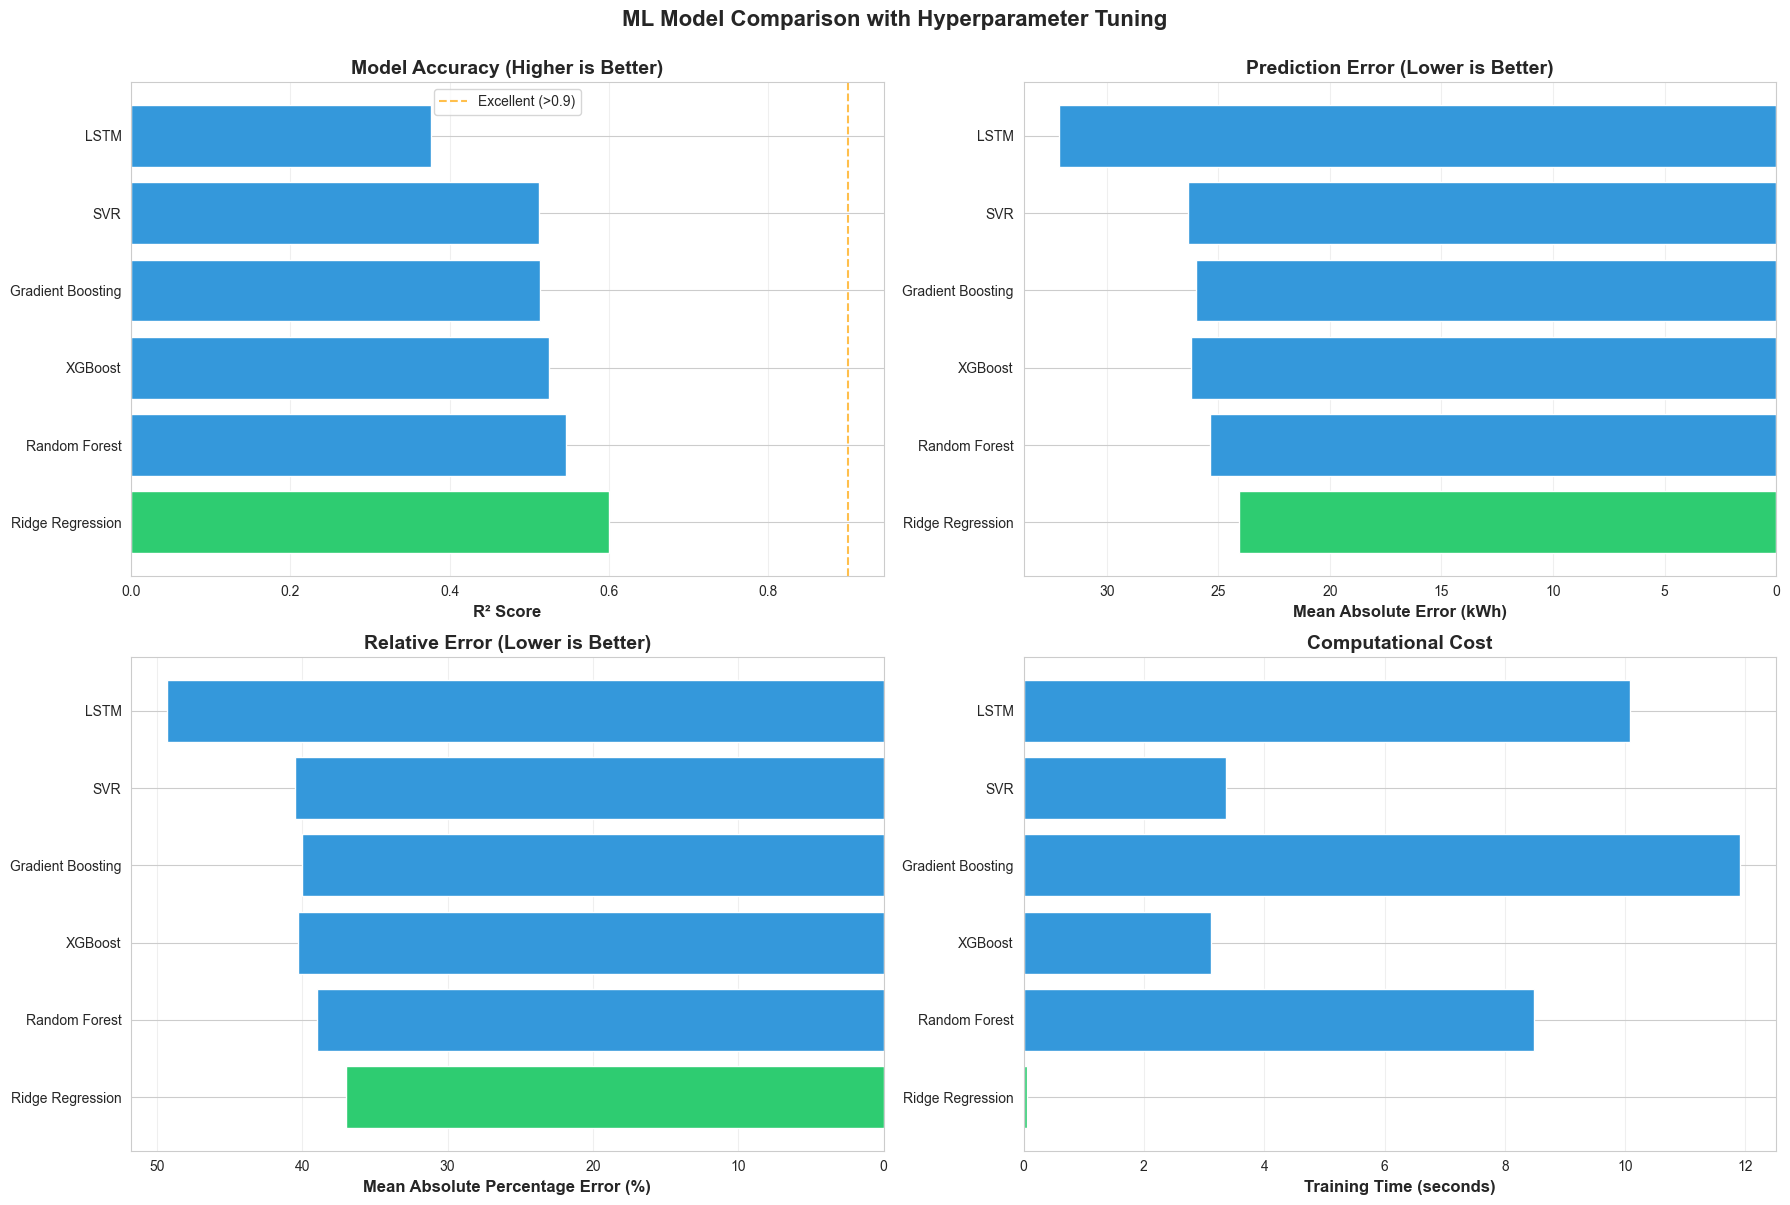

In [36]:
# Visual comparison
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

colors = ['#2ecc71' if i == 0 else '#3498db' for i in range(len(comparison_df))]

# R² Score
ax1 = axes[0, 0]
ax1.barh(comparison_df['Model'], comparison_df['Test R²'], color=colors)
ax1.set_xlabel('R² Score', fontsize=12, fontweight='bold')
ax1.set_title('Model Accuracy (Higher is Better)', fontsize=14, fontweight='bold')
ax1.axvline(x=0.9, color='orange', linestyle='--', alpha=0.7, label='Excellent (>0.9)')
ax1.legend()
ax1.grid(axis='x', alpha=0.3)

# MAE
ax2 = axes[0, 1]
ax2.barh(comparison_df['Model'], comparison_df['Test MAE (kWh)'], color=colors)
ax2.set_xlabel('Mean Absolute Error (kWh)', fontsize=12, fontweight='bold')
ax2.set_title('Prediction Error (Lower is Better)', fontsize=14, fontweight='bold')
ax2.invert_xaxis()
ax2.grid(axis='x', alpha=0.3)

# MAPE
ax3 = axes[1, 0]
ax3.barh(comparison_df['Model'], comparison_df['Test MAPE (%)'], color=colors)
ax3.set_xlabel('Mean Absolute Percentage Error (%)', fontsize=12, fontweight='bold')
ax3.set_title('Relative Error (Lower is Better)', fontsize=14, fontweight='bold')
ax3.invert_xaxis()
ax3.grid(axis='x', alpha=0.3)

# Training Time
ax4 = axes[1, 1]
ax4.barh(comparison_df['Model'], comparison_df['Training Time (s)'], color=colors)
ax4.set_xlabel('Training Time (seconds)', fontsize=12, fontweight='bold')
ax4.set_title('Computational Cost', fontsize=14, fontweight='bold')
ax4.grid(axis='x', alpha=0.3)

plt.suptitle('ML Model Comparison with Hyperparameter Tuning',
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

---
## Step 4: Three-Line Comparison Plot

**The Key Visualization**: Shows why ML is better than clear-sky

- 🔵 **Actual** = Reality
- 🟢 **ML Prediction** = Weather-adjusted expectation
- 🟠 **Clear-Sky** = Unrealistic maximum

In [37]:
def plot_three_line_comparison(test_df, predictions, best_model_key, start_date=None, end_date=None):
    """
    Plot: Actual vs ML Prediction vs Clear-Sky Maximum
    """
    plot_df = test_df.copy()
    plot_df['ml_predicted_kwh'] = predictions[best_model_key]

    # Filter date range
    if start_date:
        plot_df = plot_df[plot_df['generation_date'] >= start_date]
    if end_date:
        plot_df = plot_df[plot_df['generation_date'] <= end_date]

    # Remove NaN from LSTM lookback
    plot_df = plot_df.dropna(subset=['ml_predicted_kwh'])

    # Create figure
    fig, axes = plt.subplots(2, 1, figsize=(22, 14), height_ratios=[3, 1])

    # ===== MAIN PLOT =====
    ax1 = axes[0]

    ax1.plot(plot_df['generation_date'], plot_df['clearsky_expected_kwh'],
            color='#FF6B6B', linewidth=2.5, alpha=0.7,
            label='🟠 Clear-Sky Maximum (Theoretical - Too Optimistic)', linestyle='--')

    ax1.plot(plot_df['generation_date'], plot_df['ml_predicted_kwh'],
            color='#4ECDC4', linewidth=2.5, alpha=0.85,
            label=f'🟢 ML Predicted ({best_model_key}) - Weather-Adjusted')

    ax1.plot(plot_df['generation_date'], plot_df['generation_kwh'],
            color='#3498DB', linewidth=2, alpha=0.9,
            label='🔵 Actual Production')

    ax1.set_title(
        f'Solar Production: ML vs Clear-Sky Comparison - {PLANT_CONFIG["name"]}\n'
        f'Green line (ML) follows actual production closely - accounts for clouds & weather\n'
        f'Red line (Clear-Sky) is unrealistically high - assumes perfect conditions',
        fontsize=16, fontweight='bold', pad=20
    )
    ax1.set_ylabel('Hourly Energy (kWh)', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=13, loc='upper left', framealpha=0.95)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(bottom=0)

    # ===== RESIDUAL PLOT =====
    ax2 = axes[1]

    residuals = plot_df['generation_kwh'] - plot_df['ml_predicted_kwh']
    threshold = residuals.std() * 2
    colors_res = ['red' if r < -threshold else 'lightblue' for r in residuals]

    ax2.bar(plot_df['generation_date'], residuals, color=colors_res, alpha=0.6, width=0.04)
    ax2.axhline(y=0, color='black', linewidth=2, linestyle='-')
    ax2.axhline(y=-threshold, color='red', linewidth=2,
               linestyle='--', alpha=0.7, label=f'Alert Threshold (-{threshold:.1f} kWh)')

    n_alerts = sum(r < -threshold for r in residuals)
    ax2.set_title(f'Residuals (Actual - ML) → {n_alerts} potential problems detected (red bars)',
                 fontsize=13, fontweight='bold', pad=10)
    ax2.set_xlabel('Date', fontsize=13, fontweight='bold')
    ax2.set_ylabel('Residual (kWh)', fontsize=12)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

    # Statistics
    print("\n" + "="*80)
    print("  COMPARISON STATISTICS")
    print("="*80)

    actual_mean = plot_df['generation_kwh'].mean()
    ml_mean = plot_df['ml_predicted_kwh'].mean()
    clearsky_mean = plot_df['clearsky_expected_kwh'].mean()

    print(f"\nAverage Hourly Production:")
    print(f"  Actual:       {actual_mean:.2f} kWh")
    print(f"  ML Predicted: {ml_mean:.2f} kWh (error: {abs(ml_mean-actual_mean)/actual_mean*100:.1f}%)")
    print(f"  Clear-Sky:    {clearsky_mean:.2f} kWh (error: {abs(clearsky_mean-actual_mean)/actual_mean*100:.1f}%)")

    ml_error = abs(ml_mean - actual_mean) / actual_mean * 100
    clearsky_error = abs(clearsky_mean - actual_mean) / actual_mean * 100

    print(f"\n📊 Accuracy Comparison:")
    print(f"  ML Model:    {ml_error:.1f}% average error")
    print(f"  Clear-Sky:   {clearsky_error:.1f}% average error")
    print(f"\n  ⭐ ML is {clearsky_error/ml_error:.1f}x more accurate than clear-sky!")
    print("="*80)

# Get best model
best_model_key = comparison_df.iloc[0]['Model']
for key in results.keys():
    if results[key]['model_name'] == best_model_key:
        best_model_key = key
        break


📈 Plotting first month of test period...



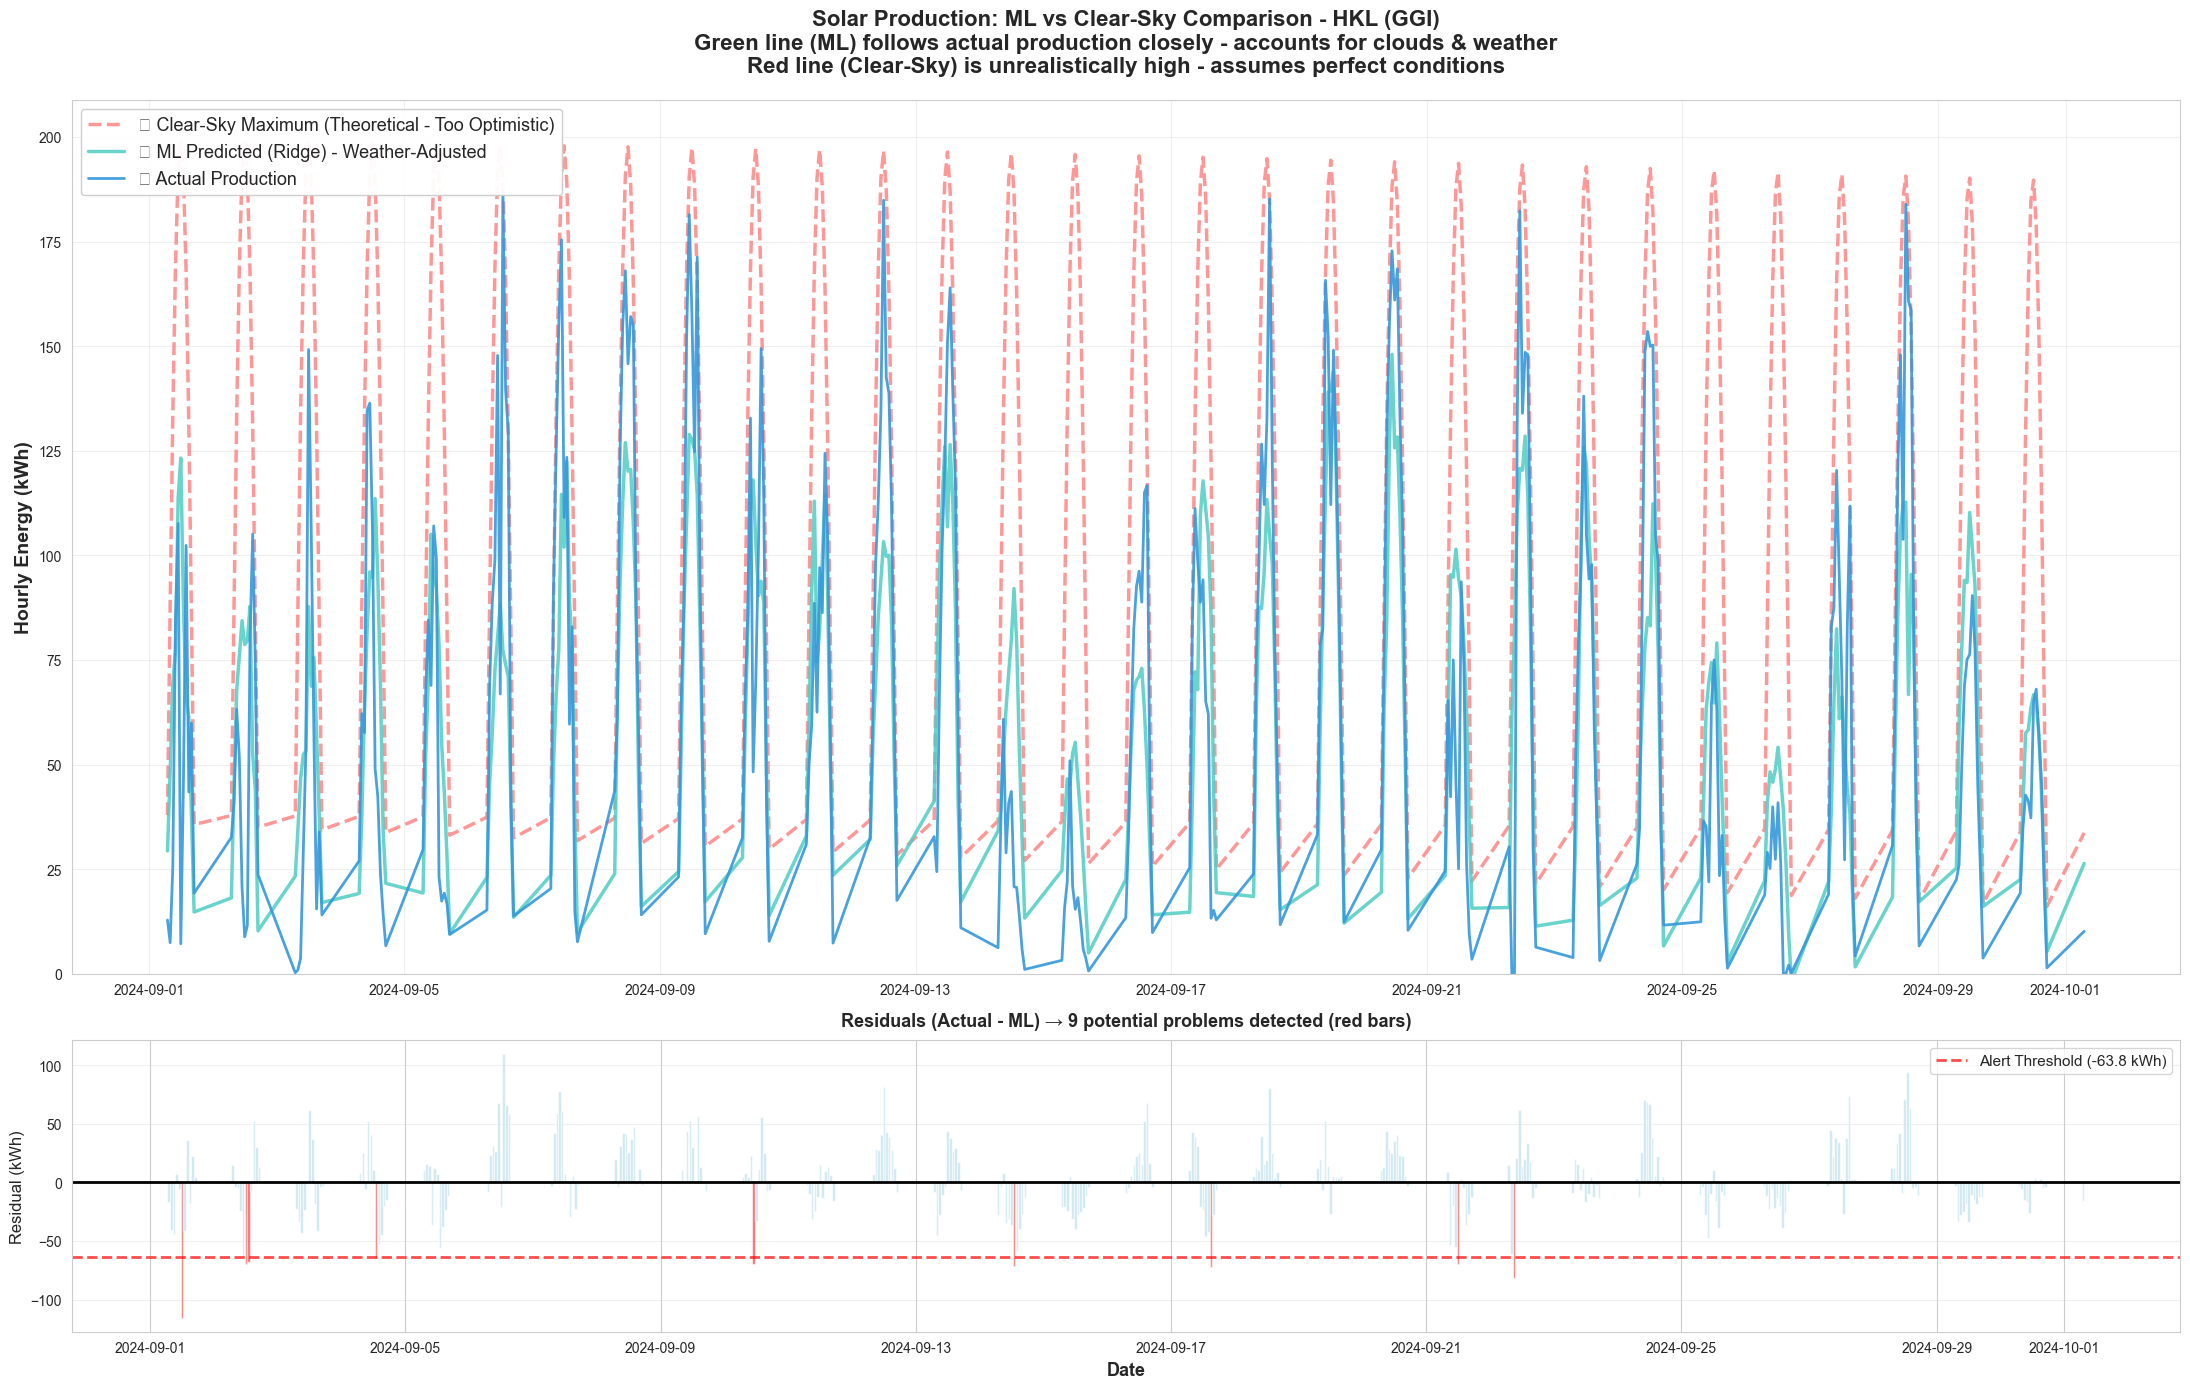


  COMPARISON STATISTICS

Average Hourly Production:
  Actual:       67.53 kWh
  ML Predicted: 65.46 kWh (error: 3.1%)
  Clear-Sky:    125.05 kWh (error: 85.2%)

📊 Accuracy Comparison:
  ML Model:    3.1% average error
  Clear-Sky:   85.2% average error

  ⭐ ML is 27.8x more accurate than clear-sky!


In [38]:
# Plot first 30 days of test set
print("\n📈 Plotting first month of test period...\n")
plot_three_line_comparison(
    test_df,
    predictions,
    best_model_key,
    start_date=test_df['generation_date'].min(),
    end_date=test_df['generation_date'].min() + pd.Timedelta(days=30)
)


📈 Plotting full test period...



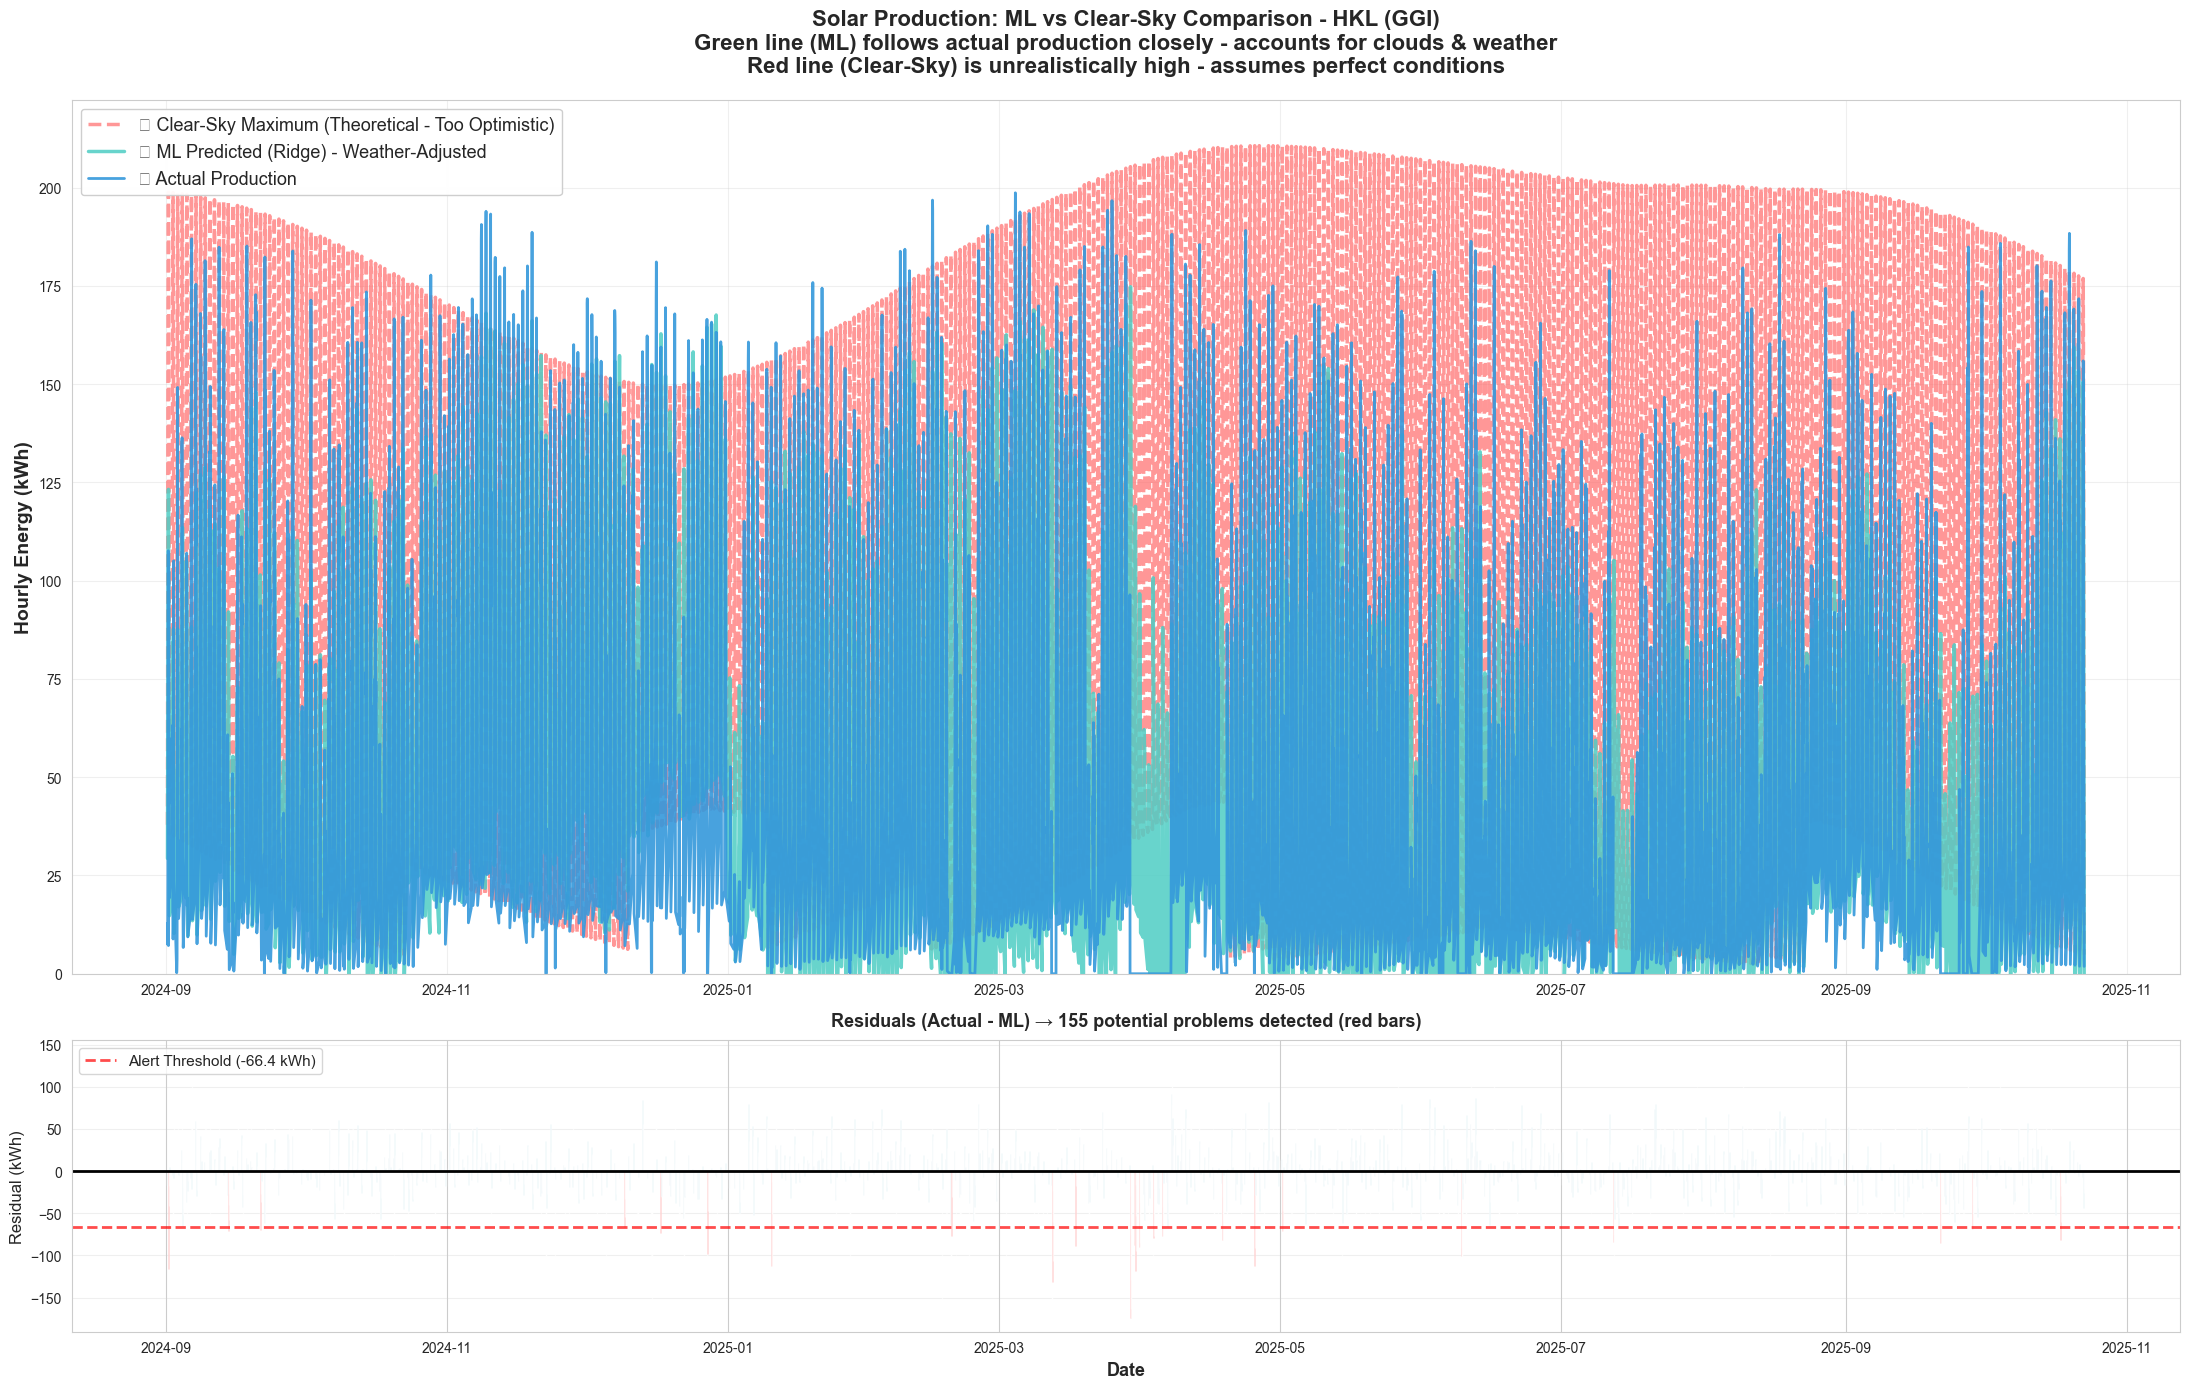


  COMPARISON STATISTICS

Average Hourly Production:
  Actual:       65.02 kWh
  ML Predicted: 64.65 kWh (error: 0.6%)
  Clear-Sky:    118.11 kWh (error: 81.7%)

📊 Accuracy Comparison:
  ML Model:    0.6% average error
  Clear-Sky:   81.7% average error

  ⭐ ML is 146.7x more accurate than clear-sky!


In [39]:
# Plot entire test period
print("\n📈 Plotting full test period...\n")
plot_three_line_comparison(test_df, predictions, best_model_key)

---
## Step 5: Feature Importance Analysis

What features drive the predictions?

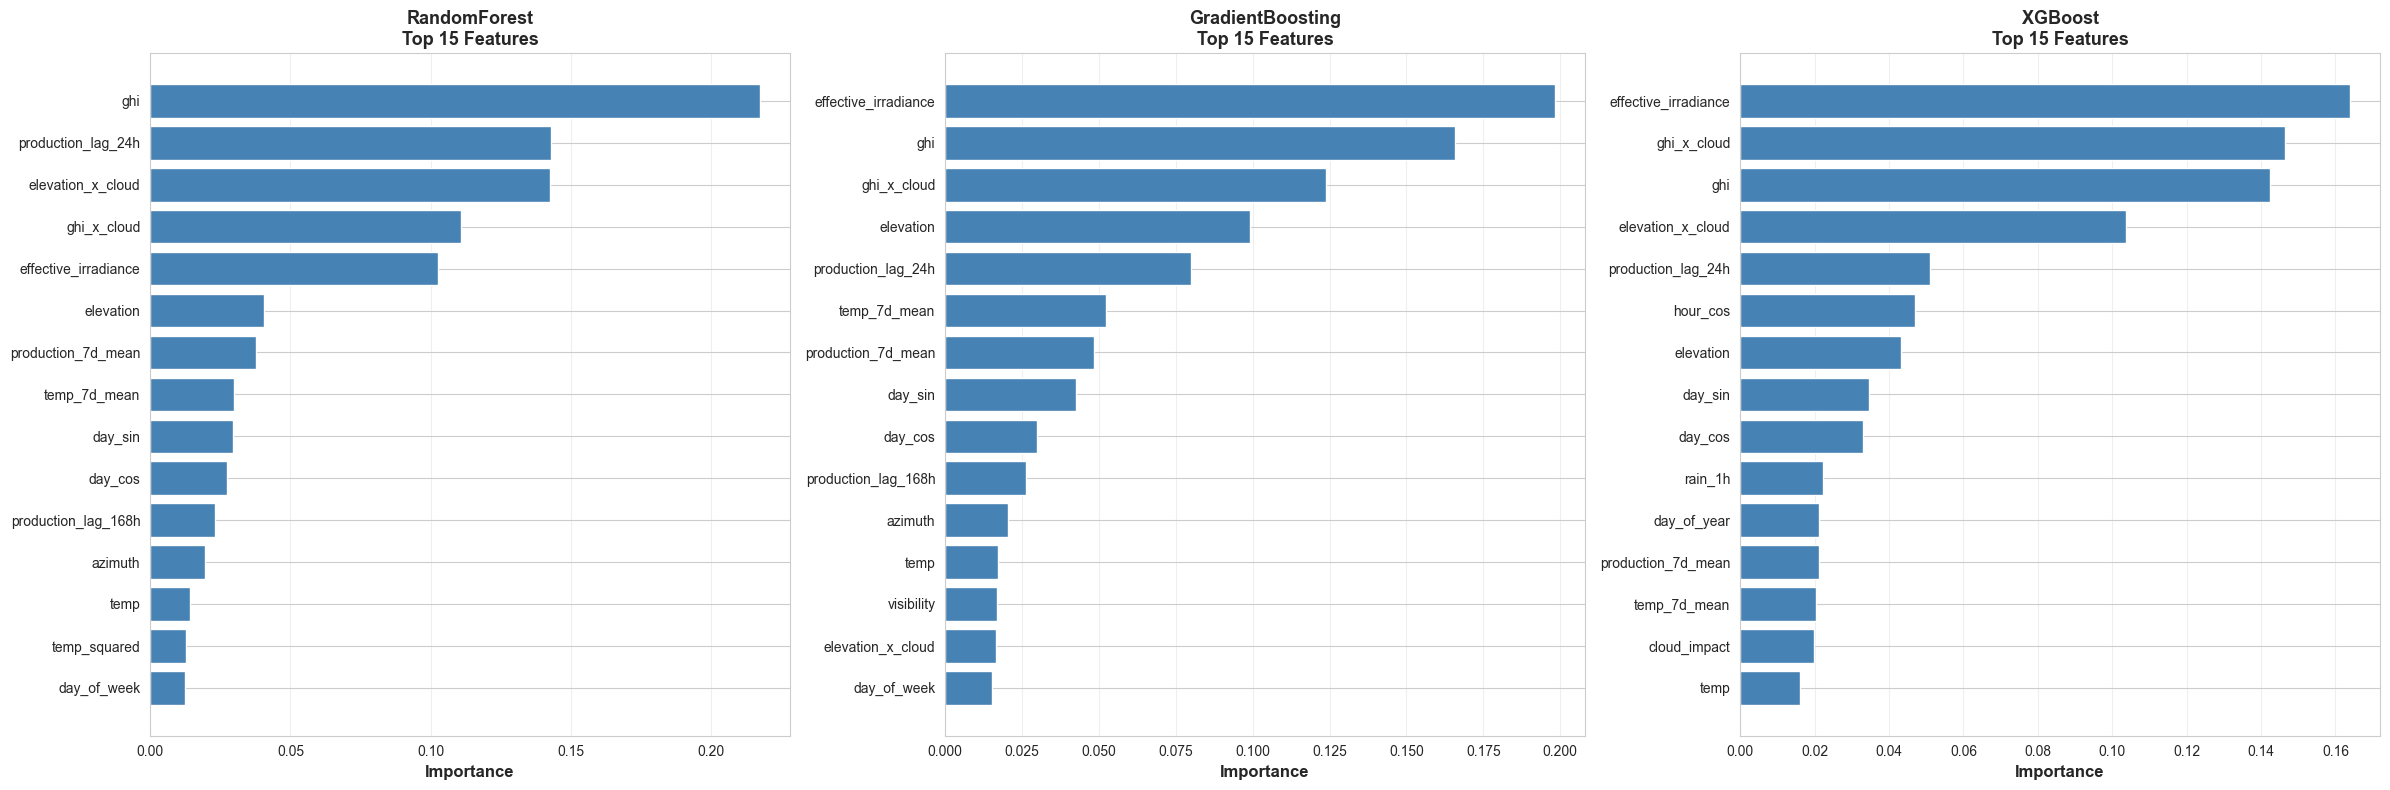

In [40]:
# Feature importance for tree-based models
tree_models = ['RandomForest', 'GradientBoosting', 'XGBoost']
available_tree_models = [m for m in tree_models if m in results]

if available_tree_models:
    fig, axes = plt.subplots(1, len(available_tree_models),
                            figsize=(8*len(available_tree_models), 8))

    if len(available_tree_models) == 1:
        axes = [axes]

    for idx, model_name in enumerate(available_tree_models):
        model = results[model_name]['model']

        importance_df = pd.DataFrame({
            'feature': feature_cols,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False).head(15)

        axes[idx].barh(range(len(importance_df)), importance_df['importance'],
                      color='steelblue')
        axes[idx].set_yticks(range(len(importance_df)))
        axes[idx].set_yticklabels(importance_df['feature'])
        axes[idx].invert_yaxis()
        axes[idx].set_xlabel('Importance', fontsize=12, fontweight='bold')
        axes[idx].set_title(f'{model_name}\nTop 15 Features',
                           fontsize=13, fontweight='bold')
        axes[idx].grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print top features
    best_tree_model = [m for m in available_tree_models if m == best_model_key]
    if best_tree_model:
        model = results[best_tree_model[0]]['model']
        importance_df = pd.DataFrame({
            'feature': feature_cols,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)

        print(f"\n🔍 Top 10 Most Important Features ({best_tree_model[0]}):")
        print(importance_df.head(10).to_string(index=False))

---
## Export Results

In [41]:
import pickle
import os

os.makedirs('output', exist_ok=True)

# Export best model
best_model_obj = results[best_model_key]
with open('output/best_model.pkl', 'wb') as f:
    pickle.dump(best_model_obj, f)

# Export feature columns
with open('output/feature_columns.pkl', 'wb') as f:
    pickle.dump(feature_cols, f)

# Export comparison
comparison_df.to_csv('output/model_comparison.csv', index=False)

# Export best hyperparameters
if best_params:
    with open('output/best_hyperparameters.pkl', 'wb') as f:
        pickle.dump(best_params, f)

print(f"✅ Best model ({best_model_key}) exported to output/best_model.pkl")
print("✅ Feature columns saved")
print("✅ Comparison results saved")
if best_params:
    print("✅ Best hyperparameters saved")

print(f"\n📦 All files saved in output/ directory")

✅ Best model (Ridge) exported to output/best_model.pkl
✅ Feature columns saved
✅ Comparison results saved
✅ Best hyperparameters saved

📦 All files saved in output/ directory


In [ ]:
# """
# COPY-PASTE THIS CELL AT THE END OF HKL_ML_comparison_v2.ipynb
# This will export all necessary files for the Streamlit dashboard
# """

# # ==================================================================================
# # EXPORT FOR STREAMLIT DASHBOARD
# # ==================================================================================

# import pickle
# from pathlib import Path

# print("=" * 80)
# print("EXPORTING PREDICTIONS FOR STREAMLIT DASHBOARD")
# print("=" * 80)

# # Create directories
# Path('data').mkdir(exist_ok=True)
# Path('models').mkdir(exist_ok=True)

# # 1. Prepare full dataset with predictions
# full_predictions_df = df_hour.copy()

# # Initialize ml_predicted_kwh column
# full_predictions_df['ml_predicted_kwh'] = np.nan

# # Add Ridge predictions to test set
# full_predictions_df.loc[test_df.index, 'ml_predicted_kwh'] = predictions_ridge

# # Add predictions for training set (optional but recommended for full coverage)
# if len(train_df) > 0:
#     train_features = train_df[feature_columns]
#     train_predictions = best_ridge_model.predict(train_features)
#     full_predictions_df.loc[train_df.index, 'ml_predicted_kwh'] = train_predictions
#     print(f"✅ Added predictions for {len(train_df)} training samples")

# print(f"✅ Added predictions for {len(test_df)} test samples")

# # 2. Verify required columns exist
# required_columns = ['generation_kwh', 'ml_predicted_kwh', 'clearsky_expected_kwh']

# missing_columns = [col for col in required_columns if col not in full_predictions_df.columns]
# if missing_columns:
#     print(f"❌ ERROR: Missing columns: {missing_columns}")
# else:
#     print(f"✅ All required columns present: {required_columns}")

# # 3. Export to parquet (efficient format for Streamlit)
# export_df = full_predictions_df[required_columns].copy()

# # Remove any NaN predictions (if any remain)
# export_df_clean = export_df.dropna(subset=['ml_predicted_kwh'])

# export_df_clean.to_parquet('data/predictions.parquet')
# print(f"✅ Exported {len(export_df_clean)} rows to data/predictions.parquet")
# print(f"   Date range: {export_df_clean.index.min()} to {export_df_clean.index.max()}")

# # 4. Export the trained Ridge model
# with open('models/ridge_model.pkl', 'wb') as f:
#     pickle.dump(best_ridge_model, f)
# print("✅ Exported trained Ridge model to models/ridge_model.pkl")
# print(f"   Model parameters: alpha={best_ridge_params['alpha']}")

# # 5. Export feature columns for future reference
# with open('models/feature_columns.pkl', 'wb') as f:
#     pickle.dump(feature_columns, f)
# print(f"✅ Exported {len(feature_columns)} feature columns to models/feature_columns.pkl")

# # 6. Export model performance metrics
# metrics_dict = {
#     'model_name': 'Ridge Regression',
#     'test_mae': test_mae_ridge,
#     'test_rmse': test_rmse_ridge,
#     'test_r2': test_r2_ridge,
#     'test_mape': test_mape_ridge,
#     'best_params': best_ridge_params,
#     'num_features': len(feature_columns),
#     'train_samples': len(train_df),
#     'test_samples': len(test_df),
#     'export_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
# }

# with open('models/model_metrics.pkl', 'wb') as f:
#     pickle.dump(metrics_dict, f)
# print("✅ Exported model metrics to models/model_metrics.pkl")

# print("\n" + "=" * 80)
# print("✅ EXPORT COMPLETE - STREAMLIT DASHBOARD IS READY!")
# print("=" * 80)
# print("\n🚀 To launch the dashboard, run in terminal:")
# print("\n   streamlit run app_solar_monitoring.py")
# print("\n📖 For detailed instructions, see: README_STREAMLIT.md")
# print("=" * 80)


EXPORTING PREDICTIONS FOR STREAMLIT DASHBOARD


NameError: name 'df_hour' is not defined

In [43]:
# ==================================================================================
# EXPORT FOR STREAMLIT DASHBOARD
# ==================================================================================

import pickle
from pathlib import Path

print("=" * 80)
print("EXPORTING PREDICTIONS FOR STREAMLIT DASHBOARD")
print("=" * 80)

# Create directories
Path('data').mkdir(exist_ok=True)
Path('models').mkdir(exist_ok=True)

# 1. Prepare full dataset with predictions
# Fixed: Use 'df_hourly' instead of 'df_hour' (typo). It's a copy of 'df', so this preserves the full dataset.
full_predictions_df = df_hourly.copy()

# Initialize ml_predicted_kwh column
full_predictions_df['ml_predicted_kwh'] = np.nan

# Add Ridge predictions to test set
# Fixed: Use 'predictions['Ridge']' instead of 'predictions_ridge'.
full_predictions_df.loc[test_df.index, 'ml_predicted_kwh'] = predictions['Ridge']

# Add predictions for training set (optional but recommended for full coverage)
if len(train_df) > 0:
    # Fixed: Use 'feature_cols' instead of 'feature_columns'.
    train_features = train_df[feature_cols]
    # Fixed: Use 'model_ridge' instead of 'best_ridge_model'.
    train_predictions = model_ridge.predict(train_features)
    full_predictions_df.loc[train_df.index, 'ml_predicted_kwh'] = train_predictions
    print(f"✅ Added predictions for {len(train_df)} training samples")

print(f"✅ Added predictions for {len(test_df)} test samples")

# 2. Verify required columns exist
# Added: A quick check to ensure 'generation_date' is the index if needed (from script, it might not be—reset if necessary).
if 'generation_date' not in full_predictions_df.columns:
    full_predictions_df = full_predictions_df.reset_index()  # Ensures we have the date column for date range printing.
required_columns = ['generation_kwh', 'ml_predicted_kwh', 'clearsky_expected_kwh']

missing_columns = [col for col in required_columns if col not in full_predictions_df.columns]
if missing_columns:
    print(f"❌ ERROR: Missing columns: {missing_columns}")
else:
    print(f"✅ All required columns present: {required_columns}")

# 3. Export to parquet (efficient format for Streamlit)
export_df = full_predictions_df[required_columns].copy()

# Remove any NaN predictions (if any remain)
export_df_clean = export_df.dropna(subset=['ml_predicted_kwh'])
# Added: Set index to 'generation_date' if available for better parquet handling (common in time series).
if 'generation_date' in full_predictions_df.columns:
    export_df_clean = export_df_clean.set_index(full_predictions_df['generation_date'].loc[export_df_clean.index])
export_df_clean.to_parquet('data/predictions.parquet')
print(f"✅ Exported {len(export_df_clean)} rows to data/predictions.parquet")
# Fixed: Use .index.min/max() since it might be a DatetimeIndex now.
print(f"   Date range: {export_df_clean.index.min()} to {export_df_clean.index.max()}")

# 4. Export the trained Ridge model
with open('models/ridge_model.pkl', 'wb') as f:
    # Fixed: Use 'model_ridge' instead of 'best_ridge_model'.
    pickle.dump(model_ridge, f)
print("✅ Exported trained Ridge model to models/ridge_model.pkl")
# Fixed: Use 'best_params['Ridge']' instead of 'best_ridge_params'.
print(f"   Model parameters: alpha={best_params['Ridge']['alpha']}")

# 5. Export feature columns for future reference
with open('models/feature_columns.pkl', 'wb') as f:
    # Fixed: Use 'feature_cols' instead of 'feature_columns'.
    pickle.dump(feature_cols, f)
print(f"✅ Exported {len(feature_cols)} feature columns to models/feature_columns.pkl")

# 6. Export model performance metrics
metrics_dict = {
    'model_name': 'Ridge Regression',
    # Fixed: Use values from 'metrics_ridge' dictionary.
    'test_mae': metrics_ridge['test_mae'],
    'test_rmse': metrics_ridge['test_rmse'],
    'test_r2': metrics_ridge['test_r2'],
    'test_mape': metrics_ridge['test_mape'],
    'best_params': best_params['Ridge'],
    # Fixed: Use 'feature_cols' instead of 'feature_columns'.
    'num_features': len(feature_cols),
    'train_samples': len(train_df),
    'test_samples': len(test_df),
    'export_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
}

with open('models/model_metrics.pkl', 'wb') as f:
    pickle.dump(metrics_dict, f)
print("✅ Exported model metrics to models/model_metrics.pkl")

print("\n" + "=" * 80)
print("✅ EXPORT COMPLETE - STREAMLIT DASHBOARD IS READY!")
print("=" * 80)
print("\n🚀 To launch the dashboard, run in terminal:")
print("\n   streamlit run app_solar_monitoring.py")
print("\n📖 For detailed instructions, see: README_STREAMLIT.md")
print("=" * 80)

EXPORTING PREDICTIONS FOR STREAMLIT DASHBOARD
✅ Added predictions for 2864 training samples
✅ Added predictions for 4676 test samples
✅ All required columns present: ['generation_kwh', 'ml_predicted_kwh', 'clearsky_expected_kwh']
✅ Exported 7540 rows to data/predictions.parquet
   Date range: 2024-01-01 08:00:00+06:00 to 2025-10-22 17:00:00+06:00
✅ Exported trained Ridge model to models/ridge_model.pkl
   Model parameters: alpha=100.0
✅ Exported 25 feature columns to models/feature_columns.pkl
✅ Exported model metrics to models/model_metrics.pkl

✅ EXPORT COMPLETE - STREAMLIT DASHBOARD IS READY!

🚀 To launch the dashboard, run in terminal:

   streamlit run app_solar_monitoring.py

📖 For detailed instructions, see: README_STREAMLIT.md
